# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Gold Spot Price Predictor

The challenge of this project is to accurately predict the future selling value of a given commodity across a given period of time in the future. For this project I will use a [Long Short Term Memory networks – usually just called “LSTMs”](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to predict the selling price of the [London Metal Exchange](https://www.quandl.com/data/LME-London-Metal-Exchange) using a dataset of past prices


## Get the Data

In the following cells we download and save the [London Metal Exchange](https://www.quandl.com/data/LME-London-Metal-Exchange).

**Step 1 :** Define a function to get historical data from Quandl

In [1]:
import datetime
import sys
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
from pandas.tseries.offsets import *
import numpy as np # fundamental package for scientific computing with Python
import math
# Pretty display for notebooks
%matplotlib inline

import quandl
quandl.ApiConfig.api_key = "2rz93HrjCax7knFkwXAJ"

# Henry Hub Natural Gas Spot Price - DHHNGSP
# Conventional Gasoline Prices: New York Harbor, Regular - DGASNYH
# China / U.S. Foreign Exchange Rate - DEXCHUS
# 1-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar - USD1MTD156N
# Gold Price: London Fixing - LBMA/GOLD (https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing)
# Silver Price: London Fixing - LBMA/SILVER (https://www.quandl.com/data/LBMA/SILVER)


**Step 2:** get the data of desired features from Fred & Other sources.

In [2]:
preData_gold = pd.read_csv('gold-spot-price-trim.csv')
#Print the dataframe head and tail
print(preData_gold.head())
print("---")
print(preData_gold.tail())

display(preData_gold.describe())
display(preData_gold.head(n=3))

         Date     Open    Close  USD1MTD156N  Silver  DGASNYH  DEXCHUS
0  2018-06-22  1269.70  1269.15      2.09775  16.425    2.011   6.5027
1  2018-06-21  1263.70  1266.15      2.09113  16.245    1.964   6.4900
2  2018-06-20  1273.25  1274.20      2.08363  16.285    1.967   6.4713
3  2018-06-19  1279.00  1276.15      2.08788  16.355    1.986   6.4802
4  2018-06-18  1281.25  1281.55      2.08375  16.605    1.991   6.4379
---
            Date    Open   Close  USD1MTD156N  Silver  DGASNYH  DEXCHUS
8360  1985-05-28  313.90  311.25       7.1875  6.1470    0.421   3.2095
8361  1985-05-24  316.35  314.70       7.1875  6.1550    0.431   3.2159
8362  1985-05-23  316.40  315.40       7.1875  6.2000    0.418   3.2159
8363  1985-05-22  317.40  316.25       7.1875  6.2150    0.436   3.2233
8364  1985-05-21  316.50  314.90       7.1250  6.5575    0.468   3.2223


,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
count,8365.000000,8365.000000,8365.000000,8365.000000,8365.000000,8365.000000
mean,664.761315,659.428338,3.524909,10.607478,1.213245,6.525621
std,440.147029,442.213798,2.790005,8.174661,0.852358,2.043938
min,252.900000,0.000000,0.000000,3.547500,0.000000,0.000000
25%,349.000000,347.600000,0.447500,4.990000,0.546000,5.789400
50%,403.750000,402.450000,3.375000,6.130000,0.821000,6.826100
75%,1099.750000,1093.250000,5.656250,16.000000,1.829000,8.277100
max,1896.500000,1895.000000,10.312500,48.700000,3.665000,8.740900


,Date,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
0,2018-06-22,1269.70,1269.15,2.09775,16.425,2.011,6.5027
1,2018-06-21,1263.70,1266.15,2.09113,16.245,1.964,6.4900
2,2018-06-20,1273.25,1274.20,2.08363,16.285,1.967,6.4713


**Step 2 :** Remove Unncessary data, i.e., Date and High value

In [3]:
preData_gold['Date'] =  pd.to_datetime(preData_gold['Date'], format='%Y-%m-%d')

In [4]:
#preData_gold['Date'].loc[preData_gold['Close']==0]

In [5]:
#preData_gold['Date'].loc[preData_gold['USD1MTD156N']==0]

In [6]:
#preData_gold['Date'].loc[preData_gold['DGASNYH']==0]

In [7]:
#preData_gold['Date'].loc[preData_gold['DEXCHUS']==0]

In [8]:
# Addressing missing values by taking average of the previous and next day value
# Close rates
for zer_date in preData_gold['Date'].loc[preData_gold['Close']==0]:
    #print('Close', preData_gold.ix[preData_gold['Date']==zer_date,['Close']])
    new_val = preData_gold['Open'].loc[preData_gold['Date']==zer_date].astype('float')
    #print(new_val)
    preData_gold.loc[preData_gold['Date']==zer_date,['Close']]=new_val
    #print('Close', preData_gold.ix[preData_gold['Date']==zer_date,['Close']])
#preData_gold.describe()

In [9]:
# Addressing missing values by taking average of the previous and next day value
# LIBOR rates: USD1MTD156N
for zer_date in preData_gold['Date'].loc[preData_gold['USD1MTD156N']==0]:
    curr_val = preData_gold['USD1MTD156N'].loc[preData_gold['Date']==zer_date]
    prev_val = preData_gold['USD1MTD156N'].loc[preData_gold['Date']==(zer_date - pd.DateOffset(days=1))]
    next_val = preData_gold['USD1MTD156N'].loc[preData_gold['Date']==(zer_date + pd.DateOffset(days=1))]
    fix_val = preData_gold['USD1MTD156N'].loc[preData_gold['Date']==(zer_date + pd.DateOffset(days=3))]
    if next_val.empty:
        #next day is empty
        if prev_val.empty: 
            # previous day is empty
            # both past and future day has no value, assigned past 3 day value
            #print (zer_date, 'both past and future day has no value', float(fix_val.astype('float')))
            new_val = float(fix_val.astype('float'))
        else:
            #previous day value should be assigned to current day
            #print (zer_date, 'previous date', float(prev_val.astype('float')))
            if float(prev_val.astype('float')) == 0:
                new_val = float(fix_val.astype('float'))
            else:
                new_val = float(prev_val.astype('float'))
    else:
        #next day is not empty
        if prev_val.empty: #previous day is empty
            # future day has value, past date does not
            #print (zer_date, 'next date', float(next_val.astype('float')))
            if float(next_val.astype('float')) == 0:
                new_val = float(fix_val.astype('float'))
            else:
                new_val = float(next_val.astype('float'))
        else: 
            #both future and past date has value so the average should be assigned
            #print (zer_date, 'average', float(next_val.astype('float'))+float(prev_val.astype('float')))
            new_val = float(next_val.astype('float'))+float(prev_val.astype('float'))
    preData_gold.loc[preData_gold['Date']==zer_date,['USD1MTD156N']]=new_val
    
preData_gold.describe()

,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
count,8365.000000,8365.000000,8365.000000,8365.000000,8365.000000,8365.000000
mean,664.761315,664.540281,3.685878,10.607478,1.213245,6.525621
std,440.147029,439.977364,2.843177,8.174661,0.852358,2.043938
min,252.900000,252.800000,0.147750,3.547500,0.000000,0.000000
25%,349.000000,349.000000,0.767780,4.990000,0.546000,5.789400
50%,403.750000,403.950000,3.687500,6.130000,0.821000,6.826100
75%,1099.750000,1100.000000,5.687500,16.000000,1.829000,8.277100
max,1896.500000,1895.000000,20.375000,48.700000,3.665000,8.740900


In [10]:
# Addressing missing values by taking average of the previous and next day value
# Gasoline rates: DGASNYH
for zer_date in preData_gold['Date'].loc[preData_gold['DGASNYH']==0]:
    curr_val = preData_gold['DGASNYH'].loc[preData_gold['Date']==zer_date]
    prev_val = preData_gold['DGASNYH'].loc[preData_gold['Date']==(zer_date - pd.DateOffset(days=1))]
    next_val = preData_gold['DGASNYH'].loc[preData_gold['Date']==(zer_date + pd.DateOffset(days=1))]
    fix_val = preData_gold['DGASNYH'].loc[preData_gold['Date']==(zer_date + pd.DateOffset(days=3))]
    if next_val.empty:
        #next day is empty
        if prev_val.empty: 
            # previous day is empty
            # both past and future day has no value, assigned past 3 day value
            #print (zer_date, 'both past and future day has no value', float(fix_val.astype('float')))
            new_val = float(fix_val.astype('float'))
        else:
            #previous day value should be assigned to current day
            #print (zer_date, 'previous date', float(prev_val.astype('float')))
            if float(prev_val.astype('float')) == 0:
                new_val = fix_val.astype('float')
            else:
                new_val = float(prev_val.astype('float'))
    else:
        #next day is not empty
        if prev_val.empty: #previous day is empty
            # future day has value, past date does not
            #print (zer_date, 'next date', float(next_val.astype('float')))
            if float(next_val.astype('float')) == 0:
                new_val = float(fix_val.astype('float'))
            else:
                new_val = float(next_val.astype('float'))
        else: 
            #both future and past date has value so the average should be assigned
            #print (zer_date, 'average', float(next_val.astype('float'))+float(prev_val.astype('float')))
            new_val = float(next_val.astype('float'))+float(prev_val.astype('float'))
    preData_gold.loc[preData_gold['Date']==zer_date,['DGASNYH']]=new_val
    
preData_gold.describe()

,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
count,8365.000000,8365.000000,8365.000000,8365.000000,8357.000000,8365.000000
mean,664.761315,664.540281,3.685878,10.607478,1.282690,6.525621
std,440.147029,439.977364,2.843177,8.174661,0.880048,2.043938
min,252.900000,252.800000,0.147750,3.547500,0.290000,0.000000
25%,349.000000,349.000000,0.767780,4.990000,0.566000,5.789400
50%,403.750000,403.950000,3.687500,6.130000,0.885000,6.826100
75%,1099.750000,1100.000000,5.687500,16.000000,1.888000,8.277100
max,1896.500000,1895.000000,20.375000,48.700000,6.700000,8.740900


In [11]:
# Addressing missing values by taking average of the previous and next day value
# China/USD ForEx rates: DEXCHUS
for zer_date in preData_gold['Date'].loc[preData_gold['DEXCHUS']==0]:
    curr_val = preData_gold['DEXCHUS'].loc[preData_gold['Date']==zer_date]
    prev_val = preData_gold['DEXCHUS'].loc[preData_gold['Date']==(zer_date - pd.DateOffset(days=1))]
    next_val = preData_gold['DEXCHUS'].loc[preData_gold['Date']==(zer_date + pd.DateOffset(days=1))]
    fix_val = preData_gold['DEXCHUS'].loc[preData_gold['Date']==(zer_date + pd.DateOffset(days=5))]
    if next_val.empty:
        #next day is empty
        if prev_val.empty: 
            # previous day is empty
            # both past and future day has no value, assigned past 3 day value
            #print (zer_date, 'both past and future day has no value', fix_val.astype('float'))
            new_val = fix_val.astype('float')
        else:
            #previous day value should be assigned to current day
            #print (zer_date, 'previous date', float(prev_val.astype('float')))
            if float(prev_val.astype('float')) == 0:
                new_val = fix_val.astype('float')
            else:
                new_val = float(prev_val.astype('float'))
    else:
        #next day is not empty
        if prev_val.empty: #previous day is empty
            # future day has value, past date does not
            #print (zer_date, 'next date', float(next_val.astype('float')))
            if float(next_val.astype('float')) == 0:
                new_val = float(fix_val.astype('float'))
            else:
                new_val = float(next_val.astype('float'))
        else: 
            #both future and past date has value so the average should be assigned
            #print (zer_date, 'average', float(next_val.astype('float'))+float(prev_val.astype('float')))
            new_val = float(next_val.astype('float'))+float(prev_val.astype('float'))
    preData_gold.loc[preData_gold['Date']==zer_date,['DEXCHUS']]=new_val
    
preData_gold.describe()

,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
count,8365.000000,8365.000000,8365.000000,8365.000000,8357.000000,8346.000000
mean,664.761315,664.540281,3.685878,10.607478,1.282690,6.970068
std,440.147029,439.977364,2.843177,8.174661,0.880048,1.848930
min,252.900000,252.800000,0.147750,3.547500,0.290000,3.202500
25%,349.000000,349.000000,0.767780,4.990000,0.566000,6.127625
50%,403.750000,403.950000,3.687500,6.130000,0.885000,6.834200
75%,1099.750000,1100.000000,5.687500,16.000000,1.888000,8.277300
max,1896.500000,1895.000000,20.375000,48.700000,6.700000,17.443400


In [12]:
preData_gold.describe()

,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
count,8365.000000,8365.000000,8365.000000,8365.000000,8357.000000,8346.000000
mean,664.761315,664.540281,3.685878,10.607478,1.282690,6.970068
std,440.147029,439.977364,2.843177,8.174661,0.880048,1.848930
min,252.900000,252.800000,0.147750,3.547500,0.290000,3.202500
25%,349.000000,349.000000,0.767780,4.990000,0.566000,6.127625
50%,403.750000,403.950000,3.687500,6.130000,0.885000,6.834200
75%,1099.750000,1100.000000,5.687500,16.000000,1.888000,8.277300
max,1896.500000,1895.000000,20.375000,48.700000,6.700000,17.443400


**Step 3:** Write the data to a csv file.

In [13]:
preData_gold.to_csv('gold-spot-price-post-trim.csv')

# Check Point #1

This is my first checkpoint. The data has been saved to disk.

## Preprocess the data

Now it is time to preprocess the data. In the following cells we will normalise it for better prediction of data.

**Step 1 :** Get the data from csv file.

In [14]:
postData_gold = pd.read_csv('gold-spot-price-post-trim.csv')
postData_gold.head(n=3)

,Unnamed: 0,Date,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
0,0,2018-06-22,1269.70,1269.15,2.09775,16.425,2.011,6.5027
1,1,2018-06-21,1263.70,1266.15,2.09113,16.245,1.964,6.4900
2,2,2018-06-20,1273.25,1274.20,2.08363,16.285,1.967,6.4713


In [15]:
postData_gold.tail(n=3)

,Unnamed: 0,Date,Open,Close,USD1MTD156N,Silver,DGASNYH,DEXCHUS
8362,8362,1985-05-23,316.4,315.40,7.1875,6.2000,0.418,3.2159
8363,8363,1985-05-22,317.4,316.25,7.1875,6.2150,0.436,3.2233
8364,8364,1985-05-21,316.5,314.90,7.1250,6.5575,0.468,3.2223


In [16]:
print("\n")
print("Open   --- mean :", np.mean(preData_gold['Open']),  "  \t Std: ", np.std(preData_gold['Open']),  "  \t Max: ", np.max(preData_gold['Open']),  "  \t Min: ", np.min(preData_gold['Open']))
print("Close   --- mean :", np.mean(preData_gold['Close']),  "  \t Std: ", np.std(preData_gold['Close']),  "  \t Max: ", np.max(preData_gold['Close']),  "  \t Min: ", np.min(preData_gold['Close']))
print("LIBOR    --- mean :", np.mean(preData_gold['USD1MTD156N']),   "  \t Std: ", np.std(preData_gold['USD1MTD156N']),   "  \t Max: ", np.max(preData_gold['USD1MTD156N']),   "  \t Min: ", np.min(preData_gold['USD1MTD156N']))
print("Silver  --- mean :", np.mean(preData_gold['Silver']), "  \t Std: ", np.std(preData_gold['Silver']), "  \t Max: ", np.max(preData_gold['Silver']), "  \t Min: ", np.min(preData_gold['Silver']))
print("Gasoline --- mean :", np.mean(preData_gold['DGASNYH']),"  \t Std: ", np.std(preData_gold['DGASNYH']),"  \t Max: ", np.max(preData_gold['DGASNYH']),"  \t Min: ", np.min(preData_gold['DGASNYH']))
print("China/US Forex --- mean :", np.mean(preData_gold['DEXCHUS']),"  \t Std: ", np.std(preData_gold['DEXCHUS']),"  \t Max: ", np.max(preData_gold['DEXCHUS']),"  \t Min: ", np.min(preData_gold['DEXCHUS']))



Open   --- mean : 664.761315002987   	 Std:  440.12071981417347   	 Max:  1896.5   	 Min:  252.9
Close   --- mean : 664.5402809324593   	 Std:  439.9510645612627   	 Max:  1895.0   	 Min:  252.8
LIBOR    --- mean : 3.6858779665272166   	 Std:  2.8430073213796803   	 Max:  20.375   	 Min:  0.14775
Silver  --- mean : 10.60747782426781   	 Std:  8.174172303232494   	 Max:  48.7   	 Min:  3.5475
Gasoline --- mean : 1.2826898408519796   	 Std:  0.8799953204638296   	 Max:  6.7   	 Min:  0.29
China/US Forex --- mean : 6.970068236280486   	 Std:  1.8488191949733694   	 Max:  17.4434   	 Min:  3.2025


In [17]:
import preprocess_data as ppd
commodity = ppd.remove_data(postData_gold)
display(commodity.head())
commodity.describe()

,Item,Open,Close
0,0,316.50,314.90
1,1,317.40,316.25
2,2,316.40,315.40
3,3,316.35,314.70
4,4,313.90,311.25


,Item,Open,Close
count,8365.000000,8365.000000,8365.000000
mean,4182.000000,664.761315,664.540281
std,2414.911834,440.147029,439.977364
min,0.000000,252.900000,252.800000
25%,2091.000000,349.000000,349.000000
50%,4182.000000,403.750000,403.950000
75%,6273.000000,1099.750000,1100.000000
max,8364.000000,1896.500000,1895.000000


**Step 2: ** Visualise raw data.

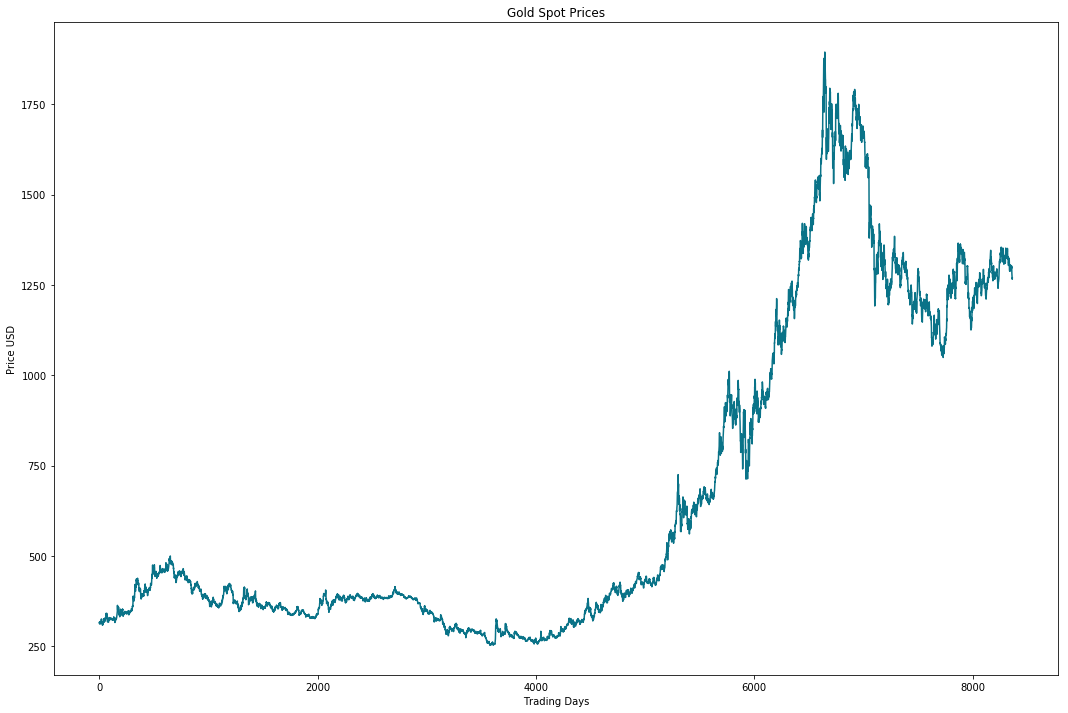

In [18]:
import visualize

visualize.plot_basic(commodity)


**Step 3 :** Normalise the data using minmaxscaler function

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = ['Open','Close']
commodity[numerical] = scaler.fit_transform(commodity[numerical])
display(commodity.head())

print("\n")
print("Open   --- mean :", np.mean(commodity['Open']), "  \t Std: ", np.std(commodity['Open']), "  \t Max: ", np.max(commodity['Open']), "  \t Min: ", np.min(commodity['Open']))
print("Close  --- mean :", np.mean(commodity['Close']),"  \t Std: ", np.std(commodity['Close']),"  \t Max: ", np.max(commodity['Close']),"  \t Min: ", np.min(commodity['Close']))


,Item,Open,Close
0,0,0.038696,0.037815
1,1,0.039243,0.038637
2,2,0.038635,0.038120
3,3,0.038604,0.037693
4,4,0.037114,0.035592




Open   --- mean : 0.25058488379349514   	 Std:  0.2677784861366361   	 Max:  1.0   	 Min:  0.0
Close  --- mean : 0.2507248087519535   	 Std:  0.267903461552346   	 Max:  1.0   	 Min:  0.0


**Step 4 :** Visualize the data again

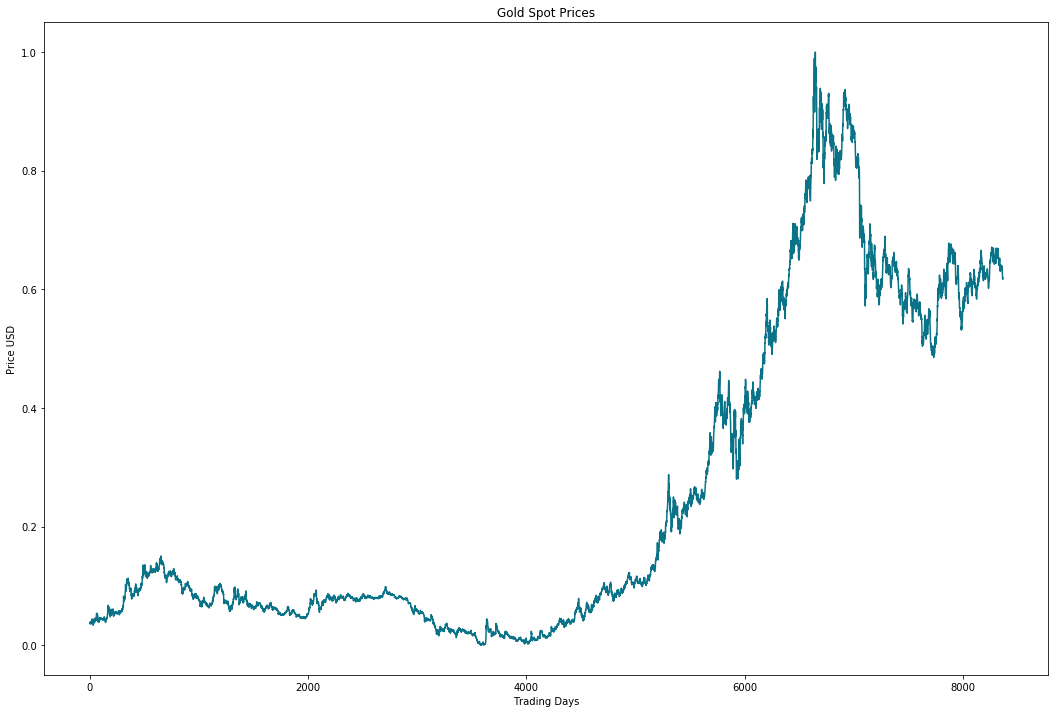

In [20]:
visualize.plot_basic(commodity)

**Step 5:** Log the normalised data for future resuablilty

In [21]:
commodity.to_csv('gold_spot_preprocessed_normalized.csv',index= False)

# Check Point #2

This is my second checkpoint. The preprocessed data has been saved to disk.

## Bench Mark Model

In this section we will check our bench mark model. As is proposed in my proposal my bench mark model is a simple linear regressor model. 

**Step 1:** Load the preprocessed data

In [22]:
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import visualize as vs
import commodity_data as cd
import LinearRegressionModel

display(commodity.head())

,Item,Open,Close
0,0,0.038696,0.037815
1,1,0.039243,0.038637
2,2,0.038635,0.038120
3,3,0.038604,0.037693
4,4,0.037114,0.035592


**Step 2:** Split data into train and test pair

In [23]:
X_train, X_test, y_train, y_test, label_range= cd.train_test_split_linear_regression(commodity)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (5731, 1)
y_train (5731, 1)
x_test (2634, 1)
y_test (2634, 1)


**Step 3:** Train a Linear regressor model on training set and get prediction

In [24]:
model = LinearRegressionModel.build_model(X_train,y_train)

**Step 4:** Get prediction on test set

In [25]:
predictions = LinearRegressionModel.predict_prices(model,X_test, label_range)

**Step 5:** Plot the predicted values against actual

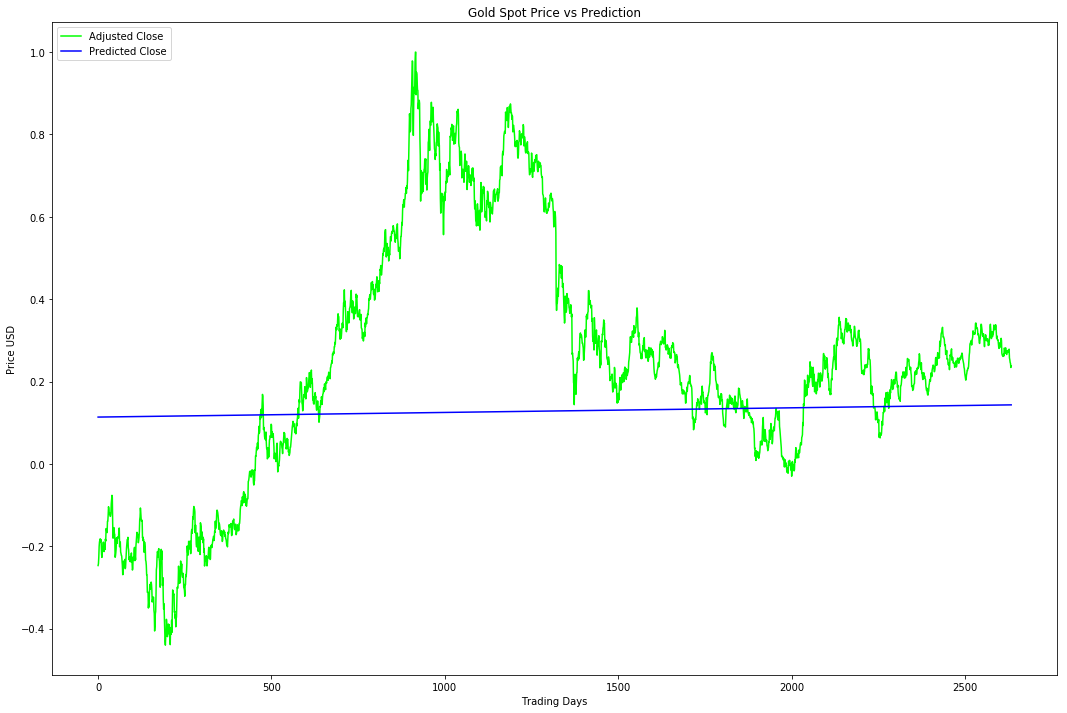

In [26]:
vs.plot_prediction(y_test,predictions)

**Step 6:** measure accuracy of the prediction

In [27]:
trainScore = mean_squared_error(X_train, y_train)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = mean_squared_error(predictions, y_test)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.4152 MSE (0.6443 RMSE)
Test Score: 0.09697600 MSE (0.31140969 RMSE)


# Checkpoint #3


## Long-Sort Term Memory Model

In this section we will use LSTM to train and test on our data set.

### Basic LSTM Model

First lets make a basic LSTM model.

**Step 1 :** Import keras libraries for smooth implementation of LSTM

In [28]:
import math
import pandas as pd
import numpy as np
from IPython.display import display

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import lstm, time #helper libraries

import visualize as vs
import commodity_data as cd
import LinearRegressionModel

commodity = pd.read_csv('gold_spot_preprocessed_normalized.csv')

commodity_ltsm = commodity.drop(['Item'], axis =1)

display(commodity_ltsm.head())

Using TensorFlow backend.


,Open,Close
0,0.038696,0.037815
1,0.039243,0.038637
2,0.038635,0.038120
3,0.038604,0.037693
4,0.037114,0.035592


**Step 2 :** Split train and test data sets and Unroll train and test data for LSTM model

In [29]:
X_train, X_test,y_train, y_test = cd.train_test_split_lstm(commodity_ltsm, 5)

unroll_length = 50
X_train = cd.unroll(X_train, unroll_length)
X_test = cd.unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (6609, 50, 2)
y_train (6609,)
x_test (1646, 50, 2)
y_test (1646,)


**Step 3 :** Build a basic Long-Short Term Memory model

In [42]:
# Set up hyperparameters
batch_size = 100
epochs = 1

# build basic lstm model
model = lstm.build_basic_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.014900922775268555


**Step 4:** Train the model

In [43]:
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.05)

Train on 6278 samples, validate on 331 samples
Epoch 1/1
6278/6278 [==============================] - 19s 3ms/step - loss: 0.0016 - val_loss: 9.4386e-04


**Step 5:** Make prediction using test data

In [44]:
predictions = model.predict(X_test)

**Step 6:** Plot the results

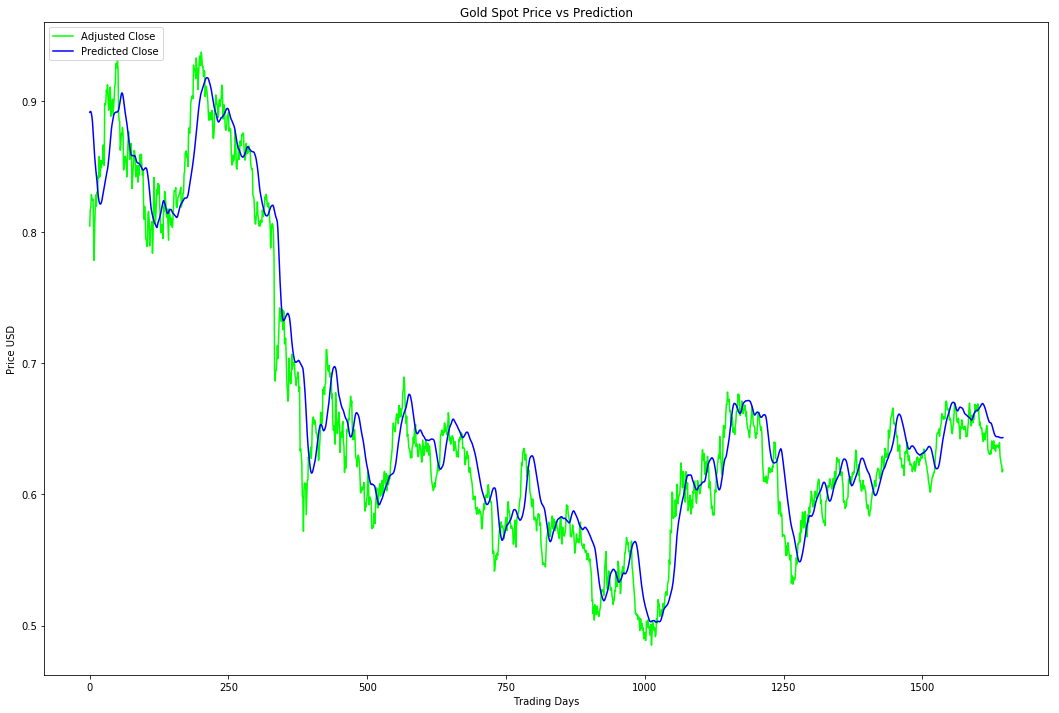

In [45]:
vs.plot_lstm_prediction(y_test,predictions)

** Step 7:** Get the test score.

In [46]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00017208 MSE (0.01311779 RMSE)
Test Score: 0.00066245 MSE (0.02573813 RMSE)


### Improved LSTM Model

**Step 1: ** Build an improved LSTM model

In [35]:
# Set up hyperparameters
batch_size = 512
epochs = 20

# build improved lstm model
model = lstm.build_improved_model( X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.017594099044799805


**Step 2: ** Train improved LSTM model

In [36]:
model.fit(X_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Train on 6278 samples, validate on 331 samples
Epoch 1/20
 - 13s - loss: 0.0054 - val_loss: 0.0241
Epoch 2/20
 - 13s - loss: 7.2900e-04 - val_loss: 0.0038
Epoch 3/20
 - 12s - loss: 4.0847e-04 - val_loss: 0.0011
Epoch 4/20
 - 11s - loss: 2.9010e-04 - val_loss: 9.8058e-04
Epoch 5/20
 - 12s - loss: 2.8004e-04 - val_loss: 0.0013
Epoch 6/20
 - 12s - loss: 2.7937e-04 - val_loss: 0.0014
Epoch 7/20
 - 10s - loss: 2.4825e-04 - val_loss: 0.0011
Epoch 8/20
 - 12s - loss: 2.6173e-04 - val_loss: 0.0019
Epoch 9/20
 - 12s - loss: 2.4718e-04 - val_loss: 0.0014
Epoch 10/20
 - 11s - loss: 2.4343e-04 - val_loss: 0.0011
Epoch 11/20
 - 10s - loss: 2.3119e-04 - val_loss: 0.0010
Epoch 12/20
 - 10s - loss: 2.3844e-04 - val_loss: 0.0016
Epoch 13/20
 - 12s - loss: 2.4268e-04 - val_loss: 0.0013
Epoch 14/20
 - 14s - loss: 2.3217e-04 - val_loss: 0.0013
Epoch 15/20
 - 12s - loss: 2.4888e-04 - val_loss: 0.0013
Epoch 16/20
 - 13s - loss: 2.2467e-04 - val_loss: 0.0010
Epoch 17/20
 - 12s - loss: 2.2251e-04 - val_loss: 

**Step 3:** Make prediction on improved LSTM model

In [37]:
# Generate predictions 
predictions = model.predict(X_test, batch_size=batch_size)

**Step 4:** plot the results

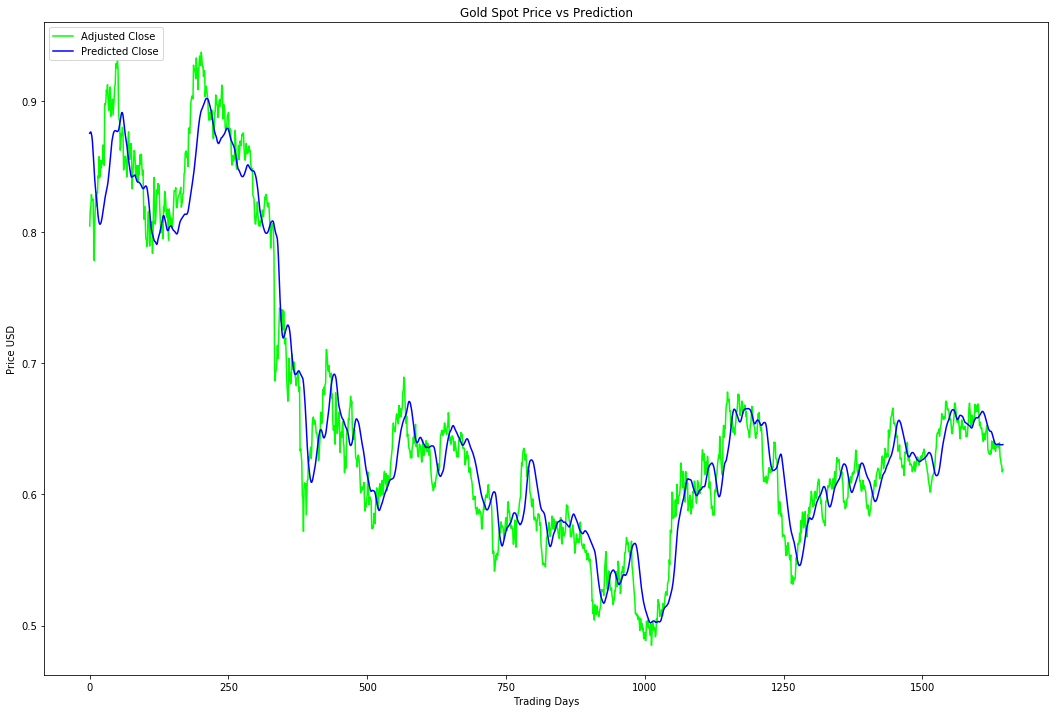

In [38]:
vs.plot_lstm_prediction(y_test,predictions)

**Step 5:** Get the test score

In [39]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00016953 MSE (0.01302042 RMSE)
Test Score: 0.00061908 MSE (0.02488127 RMSE)


In [40]:
range = [np.amin(commodity_ltsm['Close']), np.amax(commodity_ltsm['Close'])]

#Calculate the gold spot price delta in $

true_delta = testScore*(range[1]-range[0])
print('Delta Close Price: %.6f - RMSE * Adjusted Close Range' % true_delta)    

Delta Close Price: 0.000619 - RMSE * Adjusted Close Range


# Checking Robustness of the model

In this section we will check robustness of our LSTM model. I have used new unseen datasets for this from July 1, 2017 to July 20,2017. I have downloaded the data sets from google finance website to check for robustness of the model.

In [47]:
import preprocess_data as ppd

data = pd.read_csv('gold-spot-price-new-dataset.csv')

commodity = ppd.remove_data(data)

commodity_normalized = ppd.get_normalised_data(commodity)

commodity_normalized = commodity_normalized.drop(['Item'], axis = 1)
#Print the dataframe head and tail
print(commodity_normalized.head())

X = commodity_normalized[:].as_matrix()
Y = commodity_normalized[:]['Close'].as_matrix()

X = cd.unroll(X,1)
Y = Y[-X.shape[0]:]

print(X.shape)
print(Y.shape)

# Generate predictions 
predictions = model.predict(X)

#get the test score
testScore = model.evaluate(X, Y, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

       Open     Close
0  1.000000  1.000000
1  0.568259  0.688889
2  0.556314  0.477778
3  0.341297  0.364815
4  0.343003  0.324074
(14, 1, 2)
(14,)
Test Score: 0.1741 MSE (0.4172 RMSE)
